In [1]:
using DifferentialEquations
using ReactionMechanismSimulator
using PyPlot

In [2]:
outdict = readinput("chem41.rms")


[10:38:45] WARNING: not removing hydrogen atom without neighbors
[10:38:45] WARNING: not removing hydrogen atom without neighbors
┌ Warning: failed to generate StokesDiffusivity model for species vacantX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CHO2X
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species CO2HX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.jl/src/Parse.jl:352
┌ Warning: failed to generate StokesDiffusivity model for species OCX
└ @ ReactionMechanismSimulator /home/ssun30/RMG-electrocat/ReactionMechanismSimulator.j

Dict{Any, Any} with 4 entries:
  "Solvents"              => Solvent[Solvent("water", RiedelViscosity{Float64}(…
  Set(["surface", "gas"]) => Dict{Any, Any}("Reactions"=>ElementaryReaction[vac…
  "gas"                   => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…
  "surface"               => Dict{Any, Any}("Species"=>Species[Species{NASA{Emp…

In [3]:
liqspcs = outdict["gas"]["Species"]
liqrxns = outdict["gas"]["Reactions"]
surfspcs = outdict["surface"]["Species"]
surfrxns = outdict["surface"]["Reactions"]
interfacerxns = outdict[Set(["surface", "gas"])]["Reactions"]
solv = outdict["Solvents"][1];

In [4]:
liq = IdealDiluteSolution(liqspcs,liqrxns,solv,name="liquid",diffusionlimited=true);
surf = IdealSurface(surfspcs,surfrxns,3.121e-05,name="surface");

In [19]:
initialcondsliq = Dict(["proton"=>10.0^-4,
        "V"=>1.0,"T"=>298.15,"Phi"=>0.0,"d"=>0.0]);
AVratio = 1.0e5
initialcondssurf = Dict(["CO2X"=>0.1*3.121e-05*AVratio,
        "CHO2X"=>0.2*3.121e-05*AVratio,
        "CO2HX"=>0.2*3.121e-05*AVratio,
        "OX"=>0.1*3.121e-05*AVratio,
        "OCX"=>0.1*3.121e-05*AVratio,
        "vacantX"=>0.2*3.121e-05*AVratio,
        "CH2O2X"=>0.05*3.121e-05*AVratio,
        "CHO2X"=>0.04*3.121e-05*AVratio,
        "CH2OX"=>0.01*3.121e-05*AVratio,
        "A"=>1.0*AVratio,"T"=>298.15,"Phi"=>1.2]);

In [20]:
domainliq,y0liq,pliq = ConstantTVDomain(phase=liq,
    initialconds=initialcondsliq,constantspecies=["proton"]);
domaincat,y0cat,pcat = ConstantTAPhiDomain(phase=surf,
    initialconds=initialcondssurf);

In [21]:
inter,pinter = ReactiveInternalInterfaceConstantTPhi(domainliq,
  domaincat,interfacerxns,298.15,AVratio*1.0);

In [22]:
react,y0,p = Reactor((domainliq,domaincat), (y0liq,y0cat), (0.0, 1.0), [inter], (pliq,pcat,pinter));


In [23]:
@time sol = solve(react.ode,DifferentialEquations.CVODE_BDF(),abstol=1e-16,reltol=1e-6);

  0.000789 seconds (4.42 k allocations: 1.377 MiB)



[CVODES ERROR]  CVode
  At t = 0 and h = 2.86481e-28, the error test failed repeatedly or with |h| = hmin.



In [10]:
sol.retcode

ReturnCode.Success = 1

In [11]:
ssys = SystemSimulation(sol,(domainliq,domaincat,),(inter,),p);

In [12]:
rops(ssys,"CH2O2X",1)

159-element SparseArrays.SparseVector{Float64, Int64} with 36 stored entries:
  [5  ]  =  -2.48683e-25
  [6  ]  =  -1.03955e-33
  [7  ]  =  -1.31949e-35
  [8  ]  =  -1.31949e-35
  [9  ]  =  -1.44805e-31
  [10 ]  =  -1.31949e-35
  [11 ]  =  -1.31949e-35
         ⋮
  [81 ]  =  -3.44905e-44
  [90 ]  =  -2.41449e-17
  [91 ]  =  -2.17971e-19
  [108]  =  2.51436e-17
  [109]  =  3.88055e-16
  [114]  =  -5.07695e-7
  [133]  =  -1.35219e-7
  [143]  =  -9.17703e-8

In [13]:
ssys.reactions[16]

OX+CH2O2X<=>HOX+CHO2X

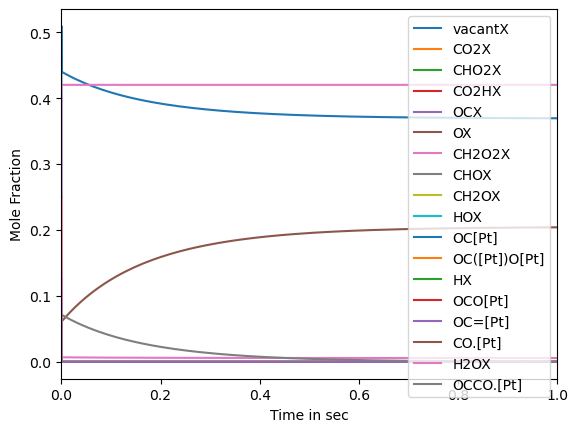

In [14]:
#Plot surface fractions
plotmolefractions(ssys.sims[2];tol=1e-9)
xlim(0.0,1)
gcf()

In [15]:
Dict([ssys.sims[2].names[i]=>molefractions(ssys.sims[2],1.0)[i] for i in 1:length(ssys.sims[2].names)])

Dict{String, Float64} with 26 entries:
  "CO2HX"         => 2.888e-24
  "CHOX"          => 4.85582e-23
  "OCCO.[Pt]"     => 0.00035095
  "CH2O2X"        => 0.420147
  "CO2X"          => 1.39788e-32
  "O=COC[Pt]"     => -9.08715e-31
  "[Pt]CO[Pt]"    => 1.78761e-38
  "OC(O)[Pt]"     => 5.99319e-25
  "HX"            => 8.70368e-13
  "OX"            => 3.92411e-28
  "OCO[Pt]"       => 1.03219e-20
  "H2OX"          => 0.00590431
  "CO[Pt]"        => 1.83333e-27
  "OC[Pt]"        => 3.24539e-11
  "OC([Pt])O[Pt]" => 1.93214e-9
  "CH2OX"         => 1.07401e-15
  "CHO2X"         => 1.31223e-24
  "HOX"           => 1.2821e-26
  "O=CCO[Pt]"     => 1.8182e-43
  ⋮               => ⋮

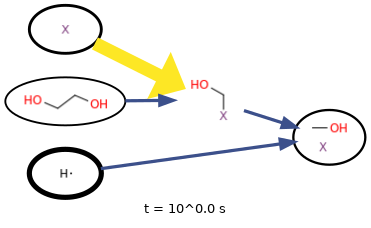

In [16]:
getfluxdiagram(ssys,1;speciesratetolerance=0.4)

In [ ]:
println(ssys.names)

In [ ]:
plotrops(ssys,"CH2O2X",1;N=15,tol=0.0)

In [ ]:
plotrops(ssys,"CHO2X",1;N=10,tol=0.0)

In [ ]:
plotrops(ssys,"CO2HX",1;N=10,tol=0.0)

In [ ]:
plotrops(ssys,"OX",1;N=10,tol=0.0)
gcf()

In [ ]:
plotrops(ssys,"OCX",1.0e-6)
gcf()

In [17]:
for (i,rxn) in enumerate(inter.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

vacantX+CO2<=>CO2X
kf = 15168.336974465617
krev = 7764.41700312789
Kc = 1.9535706246013143
proton+CO2X<=>CHO2X
kf = 8.083818277766844e11
krev = 0.010098596840759685
Kc = 8.004892566003977e13
proton+CO2X<=>CO2HX
kf = 2.273225608832448e7
krev = 2.2582764080247422e-7
Kc = 1.0066197391756758e14
proton+CHO2X<=>CH2O2X
kf = 4.576000332417186e18
krev = 1.4292097773553455e-9
Kc = 3.201769540707145e27
proton+CO2HX<=>CH2O2X
kf = 1.2555591447979036e12
krev = 4.931250238800167e-16
Kc = 2.546127420017923e27
proton+OCX<=>CHOX
kf = 1.652590254879022e14
krev = 1.4379195974444288e-9
Kc = 1.149292531944151e23
proton+CHOX<=>CH2OX
kf = 2.083412189362709e11
krev = 2.0125467095298444e-13
Kc = 1.0352118435300415e24
vacantX+vacantX+CO2<=>OX+OCX
kf = 5.720666081686702e-23
krev = 6.626491391815395e14
Kc = 8.633024240780711e-38
OX+proton<=>HOX
kf = 3.0710022311378764e19
krev = 3.2741074576736537e-6
Kc = 9.379662307479397e24
vacantX+O=CO<=>CH2O2X
kf = 296648.2669542095
krev = 19.201584999157312
Kc = 15449.15521126

In [24]:
for (i,rxn) in enumerate(inter.reactions)
    str = getrxnstr(rxn)
    kf = inter.kfs[i]
    krev = inter.krevs[i]
    Kc = kf/krev
    println(str)
    println("kf = $kf")
    println("krev = $krev")
    println("Kc = $Kc")
end

vacantX+CO2<=>CO2X
kf = 15168.336974465617
krev = 7764.41700312789
Kc = 1.9535706246013143
proton+CO2X<=>CHO2X
kf = 58.20400728960015
krev = 2.7055278049184825e28
Kc = 2.1512995425065992e-27
proton+CO2X<=>CO2HX
kf = 1.178461037943873e-13
krev = 4.356165878424675e13
Kc = 2.705271265680179e-27
proton+CHO2X<=>CH2O2X
kf = 0.023722406084196648
krev = 2.75691445170427e11
Kc = 8.604694305814214e-14
proton+CO2HX<=>CH2O2X
kf = 6.508933944917174e-9
krev = 95122.74029831383
Kc = 6.842668666298455e-14
proton+OCX<=>CHOX
kf = 8.567179691684521e-7
krev = 2.7737155044649036e11
Kc = 3.0887016631279476e-18
proton+CHOX<=>CH2OX
kf = 1.0800600176250536e-9
krev = 3.8821586558831215e7
Kc = 2.7821119984066165e-17
vacantX+vacantX+CO2<=>OX+OCX
kf = 5.720666081686702e-23
krev = 6.626491391815395e14
Kc = 8.633024240780711e-38
OX+proton<=>HOX
kf = 0.15920357674896451
krev = 6.315681791091639e14
Kc = 2.5207662769445334e-16
vacantX+O=CO<=>CH2O2X
kf = 296648.2669542095
krev = 19.201584999157312
Kc = 15449.15521126137